# Train my model to know the difference between stormy and calm sea

In [1]:
from fastai.vision.all import *

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

# * if exists

In [2]:
ims = search_images_ddg('stormy sea')
len(ims)

200

In [3]:
dest = 'images/stormy.jpg'
download_url(ims[0],dest, show_progress=False)

Path('images/stormy.jpg')

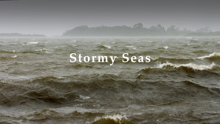

In [4]:
im = Image.open(dest)
im.to_thumb(220,220)

# * types

In [5]:
sea_types = 'stormy','calm'
path = Path('seas')

In [6]:
if not path.exists():
    path.mkdir()
    for i in sea_types:
        dest = (path/i)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{i} sea')
        download_images(dest, urls=results)

# * get paths

In [7]:
fns = get_image_files(path)
fns

(#384) [Path('seas/stormy/46d1255f-5c6b-48ad-9658-c3a51ef3e271.png'),Path('seas/stormy/0f7f3892-3225-46e0-804a-3077e707bc74.jpg'),Path('seas/stormy/4c07fcc0-ecc6-4e0f-8455-8d7357285816.jpg'),Path('seas/stormy/38dc2db1-ac31-4c93-9e15-01c87ab6f0e1.jpg'),Path('seas/stormy/071a5a11-e487-414d-884d-2c14b5c04614.jpg'),Path('seas/stormy/10b9259a-19ae-400b-a10b-0cc4c3da7547.jpg'),Path('seas/stormy/446c8c61-a295-4ee4-85a9-40c8451ba16b.jpg'),Path('seas/stormy/397affe3-e70d-441d-bfff-df6b350574ff.jpg'),Path('seas/stormy/e365f0e1-403b-485c-9d87-60dbfe67d279.jpg'),Path('seas/stormy/452c359b-d693-4e78-a68a-165545c9fac4.jpg')...]

# * delete if failed

In [8]:
failed = verify_images(fns)
failed

(#4) [Path('seas/stormy/2c4f75eb-2fbd-498d-91d1-63204f5c101d.jpg'),Path('seas/calm/2d5367b7-c83e-440a-abd7-fed90186b300.jpg'),Path('seas/calm/3ace1863-89bb-477a-96f4-3b19975ffa7e.jpg'),Path('seas/calm/a8384525-3469-4660-b83b-a0436f49ebc8.jpg')]

In [9]:
failed.map(Path.unlink)

(#4) [None,None,None,None]

# * get data 

In [10]:
seas = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [11]:
dls = seas.dataloaders(path)

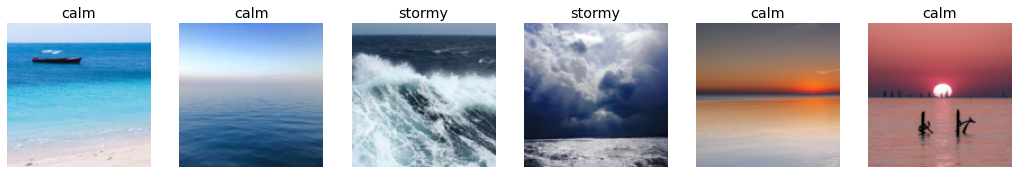

In [12]:
dls.valid.show_batch(max_n=6, nrows=1)

# just resize

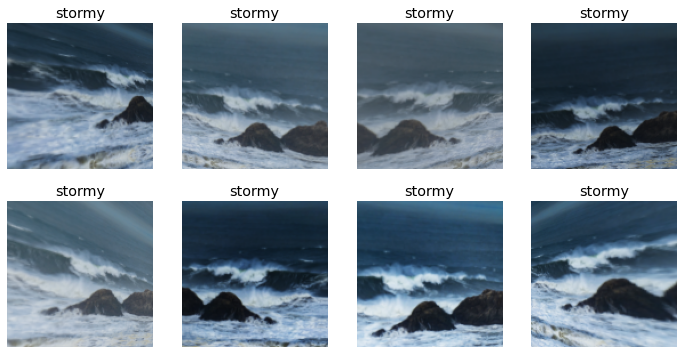

In [13]:
seas = seas.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = seas.dataloaders(path)
dls.train.show_batch(max_n=8, nrows = 2, unique = True)

# * train model

In [14]:
seas = seas.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = seas.dataloaders(path)

# * learner

In [15]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.756682,0.634239,0.197368,00:53


epoch,train_loss,valid_loss,error_rate,time
0,0.447076,0.411503,0.157895,01:01
1,0.417699,0.294124,0.118421,01:02
2,0.345712,0.291796,0.092105,01:01
3,0.295389,0.275033,0.078947,01:01


# * confusion matrix

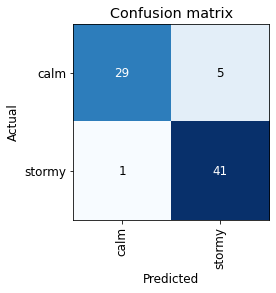

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# * prediction/actual/loss/probability(confidence)

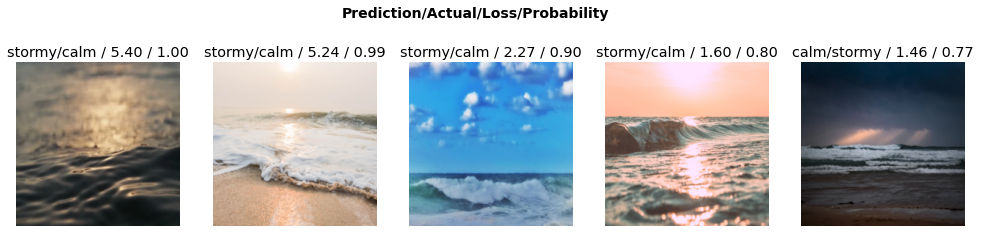

In [17]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

# * clean wrongly labeled 

In [18]:
cleaner = ImageClassifierCleaner(learn)

# * delete wrongly labeled images and move to new folder 

In [19]:
for idx in cleaner.delete():cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():shutil.move(str(cleaner.fns[idx]),path/cat)